不规则等势面的格林函数计算静电力求解

part1 球形自适应积分曲面的演化

In [2]:
import time
from scipy import sparse
import scipy
import copy
from matplotlib import interactive
interactive(True)
from math import ceil
import pandas as pd
import numba as nb
import sys
eps = 0.08854187817 # F/A
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.linalg import lu,solve
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import plotly.express as px
import plotly.graph_objects as go
from vedo import *

In [3]:
box_size = np.array([100.0,100.0,100.0]).astype("float64")
(NX,NY,NZ) = (100,100,100)
(dx,dy,dz) = (box_size[0]/NX, box_size[1]/NY, box_size[2]/NZ)

In [4]:
# 等势面形状
iso_level = 1
def sphere(crd):
     if crd[0] == 50.0 and crd[1] == 50.0 and crd[2] == 50.0 :
          return 1e10
     else:
          return 38.955/np.sqrt((crd[0]-50.0)**2 + (crd[1]-50.0)**2 + (crd[2]-50.0)**2)

In [5]:
# 初始网格坐标， 生成一个斐波那契球体作为初猜球面
def sphere_generator(N,D,Center):

  shpere_points = [[0,0,0] for _ in range(N)]
  phi = 0.5*(np.sqrt(5)-1)
  for i in range(N):
      n = i+1
      z = (2*n-1)/N-1
      x = np.sqrt(1 - z * z) * np.cos(2 * np.pi * n * phi)
      y = np.sqrt(1 - z * z) * np.sin(2 * np.pi * n * phi)
      shpere_points[i][0] = x*D + Center[0]
      shpere_points[i][1] = y*D + Center[1]
      shpere_points[i][2] = z*D + Center[2]
  return np.array(shpere_points)



In [6]:
def boundary_force(points, boundary_atom_center, k1, VDW_boundary, Attach_force):
    Acc = np.zeros_like(points)
    for i in range(points.shape[0]):
        distance = np.linalg.norm(points[i] - boundary_atom_center)
        vec = points[i] - boundary_atom_center
        if distance > VDW_boundary:
            Acc[i] += k1*vec/distance**2
        else:
            Acc[i] += k1*vec/distance**2 + Attach_force*vec/distance*(VDW_boundary-distance)**2
    return Acc

def triangle_force(points, face, k2):
    Acc = np.zeros_like(points)
    for i in range(face.shape[0]):
        a = points[face[i,0]]
        b = points[face[i,1]]
        c = points[face[i,2]]
        normal = np.cross(b-a,c-a)
        area = np.linalg.norm(normal)
        for j in range(3):
            Acc[face[i,j]] += k2*normal/area
    return Acc

def edge_force(points, edges, edge_length_init, k3, k4):
    Acc = np.zeros_like(points)
    for i in range(edges.shape[0]):
        a = points[edges[i,0]]
        b = points[edges[i,1]]
        Distance = np.linalg.norm(a-b)
        Force = (k3*np.heaviside(edge_length_init[i]-Distance,0)+k4)*(edge_length_init[i]-Distance)*(a-b)
        Acc[edges[i,0]] += Force
        Acc[edges[i,1]] -= Force
    return Acc

def center_force(points, charge_center, k5, R):
    Acc = np.zeros_like(points)
    for i in range(points.shape[0]):
        Acc[i] += k5*(2*np.heaviside(R-np.linalg.norm(points[i]-charge_center),0)-1)*(points[i]-charge_center)/np.linalg.norm(points[i]-charge_center)
    return Acc

def iteration_sphere(boundary_atom_center, charge_center, points, face, edges, edge_length_init, k1, k2, k3, k4, k5, R,  VDW_boundary, Attach_force,  dt, max_iter):
    crd = copy.deepcopy(points)
    Err  = []
    for i in range(max_iter):
        force = boundary_force(crd, boundary_atom_center, k1, VDW_boundary, Attach_force) + triangle_force(crd, face, k2) + edge_force(crd, edges, edge_length_init, k3, k4) + center_force(crd, charge_center, k5, R)
        crd += force* dt**2
        Err.append(np.linalg.norm(force))
        print("step = %d, err = %f"%(i, Err[-1]))
    return (crd, Err)

In [9]:
N_sphere = 500
R_sphere = 1
charge_crd = np.array([0 ,0, 0])
boundary_atom_center = np.array([50,50,50])
points = sphere_generator(N_sphere, R_sphere, charge_crd)
hull  = scipy.spatial.ConvexHull(points,3)
face = hull.simplices

for i in range(face.shape[0]):
        a = points[face[i,0]]
        b = points[face[i,1]]
        c = points[face[i,2]]
        normal = np.cross(b-a,c-a)
        vec_to_center  = charge_crd - (a+b+c)/3
        if np.dot(normal,vec_to_center) > 0:
            d = face[i,1]
            face[i,1] = face[i,2]
            face[i,2] = d
            

temp_edges = []
for i in range(face.shape[0]):
    vertex = np.sort(face[i])
    temp_edges.append(str(vertex[0]) + "+" + str(vertex[1]))
    temp_edges.append(str(vertex[0]) + "+" + str(vertex[2]))
    temp_edges.append(str(vertex[1]) + "+" + str(vertex[2]))
edges = np.array([np.array(i.split("+")).astype(np.int64) for i in list(set(temp_edges))])
edge_length_init = np.linalg.norm(points[edges[:,0]] - points[edges[:,1]],axis=1)

np.savetxt("unit_500Sphere/points.txt", points)
np.savetxt("unit_500Sphere/edge_length_init.txt", edge_length_init)

f_edge = open("unit_500Sphere/edges.txt", "w")
for i in range(edges.shape[0]):
    f_edge.write("%d\n%d\n"%(edges[i,0], edges[i,1]))
f_edge.close()

f_face = open("unit_500Sphere/faces.txt", "w")
for i in range(face.shape[0]):
    f_face.write("%d\n%d\n%d\n"%(face[i,0], face[i,1], face[i,2]))
f_face.close()



f_info = open("unit_500Sphere/info.txt", "w")
f_info.write("%d\n"%edges.shape[0])
f_info.write("%d\n"%face.shape[0])
f_info.close()

In [8]:
np.linalg.norm(points[3]-points[1])

0.191423488195184

In [ ]:
(k1,k2,k3,k4,k5) = (10000,50000,10000,2000,5000)
R = 9
VDW_boundary = 23
Attach_force = k1
dt = 0.0001
max_iter = 2000
(new_points, Err) = iteration_sphere(boundary_atom_center, charge_crd, points, face, edges, edge_length_init, k1, k2, k3, k4, k5, R, VDW_boundary, Attach_force, dt, max_iter)

In [ ]:
plt.plot(Err)

In [20]:
new_points = np.loadtxt("unit_500Sphere/result.txt")

In [ ]:
new_points = new_points
points = points
x = [new_points[i][0] for i in range(len(points))]
y = [new_points[i][1] for i in range(len(points))]
z = [new_points[i][2] for i in range(len(points))]

x_init = [points[i][0] for i in range(len(points))]
y_init = [points[i][1] for i in range(len(points))]
z_init = [points[i][2] for i in range(len(points))]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=3,
    )
)])

i_list = [new_points[edges[i][0]] for i in range(edges.shape[0])]
j_list = [new_points[edges[i][1]] for i in range(edges.shape[0])]
fig = go.Figure()
for start, end in zip(i_list, j_list):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]], 
        y=[start[1], end[1]], 
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color='blue')
    ))

#i_list = [points[edges[i][0]] for i in range(edges.shape[0])]
#j_list = [points[edges[i][1]] for i in range(edges.shape[0])]
#for start, end in zip(i_list, j_list):
#    fig.add_trace(go.Scatter3d(
#        x=[start[0], end[0]], 
#        y=[start[1], end[1]], 
#        z=[start[2], end[2]],
#        mode='lines',
#        line=dict(color='blue')
#    ))

iso_sphere = sphere_generator(900,20,[50,50,50])
hull  = scipy.spatial.ConvexHull(iso_sphere,3)
face = hull.simplices
temp_edges = []
for i in range(face.shape[0]):
    vertex = np.sort(face[i])
    temp_edges.append(str(vertex[0]) + "+" + str(vertex[1]))
    temp_edges.append(str(vertex[0]) + "+" + str(vertex[2]))
    temp_edges.append(str(vertex[1]) + "+" + str(vertex[2]))
iso_edges = np.array([np.array(i.split("+")).astype(np.int64) for i in list(set(temp_edges))])


i_list = [iso_sphere[iso_edges[i][0]] for i in range(iso_edges.shape[0])]
j_list = [iso_sphere[iso_edges[i][1]] for i in range(iso_edges.shape[0])]
for start, end in zip(i_list, j_list):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]], 
        y=[start[1], end[1]], 
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color='red')
    ))

fig.add_trace(go.Scatter3d(
        x=[75.], 
        y=[50.], 
        z=[50.],
    ))

fig.show()

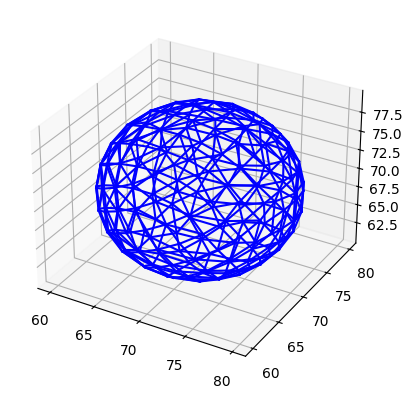

In [313]:
fig3 = plt.figure()
ax = fig3.add_subplot(1,1,1,projection='3d')
for i in range(edges.shape[0]):
    ax.plot((points[edges[i]][0][0],points[edges[i]][1][0]), 
            (points[edges[i]][0][1],points[edges[i]][1][1]),
            (points[edges[i]][0][2],points[edges[i]][1][2]), 'b-')

In [310]:
points[edges[0]][0]

array([78.48486734, 64.97162787, 68.35      ])

In [ ]:
new_points = iteration([50,50,50],[70,70,70],points,edges,10000,1000,2,edge_length_init,10,20,0.01,900)

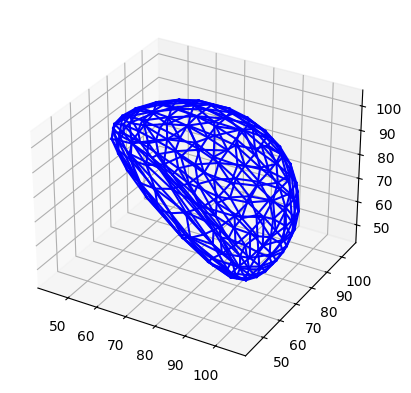

In [368]:
fig3 = plt.figure()
ax = fig3.add_subplot(1,1,1,projection='3d')
for i in range(edges.shape[0]):
    ax.plot((new_points[edges[i]][0][0],new_points[edges[i]][1][0]), 
            (new_points[edges[i]][0][1],new_points[edges[i]][1][1]),
            (new_points[edges[i]][0][2],new_points[edges[i]][1][2]), 'b-')

In [ ]:

x = [new_points[i][0] for i in range(len(points))]
y = [new_points[i][1] for i in range(len(points))]
z = [new_points[i][2] for i in range(len(points))]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
